In [66]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

In [67]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

if not os.path.exists('./data'):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

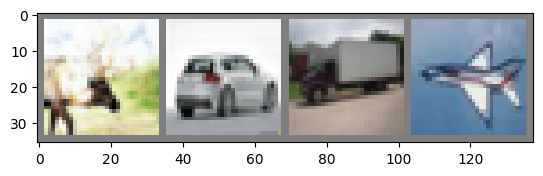

deer  car   truck plane


In [68]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [69]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [70]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [71]:
import numpy as np
losses = []
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4000 == 3999:    # print every 4000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
    losses.append(running_loss  / 2000)

print('Finished Training')

[1,  4000] loss: 4.103
[1,  8000] loss: 3.307
[1, 12000] loss: 2.942
[2,  4000] loss: 2.764
[2,  8000] loss: 2.672
[2, 12000] loss: 2.587
[3,  4000] loss: 2.418
[3,  8000] loss: 2.401
[3, 12000] loss: 2.342
[4,  4000] loss: 2.205
[4,  8000] loss: 2.215
[4, 12000] loss: 2.201
[5,  4000] loss: 2.028
[5,  8000] loss: 2.080
[5, 12000] loss: 2.094
[6,  4000] loss: 1.917
[6,  8000] loss: 1.973
[6, 12000] loss: 1.990
[7,  4000] loss: 1.834
[7,  8000] loss: 1.875
[7, 12000] loss: 1.884
[8,  4000] loss: 1.719
[8,  8000] loss: 1.804
[8, 12000] loss: 1.846
[9,  4000] loss: 1.644
[9,  8000] loss: 1.731
[9, 12000] loss: 1.767
[10,  4000] loss: 1.558
[10,  8000] loss: 1.667
[10, 12000] loss: 1.713
[11,  4000] loss: 1.513
[11,  8000] loss: 1.617
[11, 12000] loss: 1.664
[12,  4000] loss: 1.466
[12,  8000] loss: 1.563
[12, 12000] loss: 1.606
[13,  4000] loss: 1.417
[13,  8000] loss: 1.541
[13, 12000] loss: 1.585
[14,  4000] loss: 1.389
[14,  8000] loss: 1.500
[14, 12000] loss: 1.547
[15,  4000] loss: 1

<Figure size 640x480 with 0 Axes>

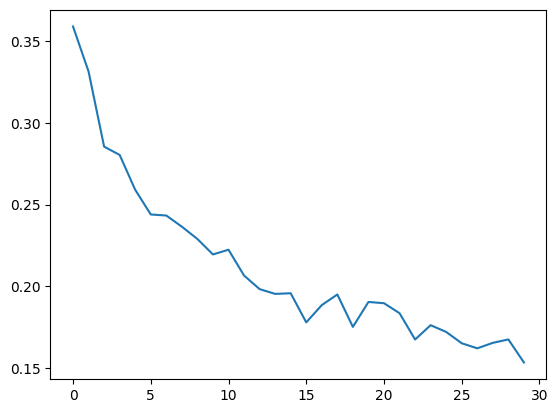

<Figure size 640x480 with 0 Axes>

In [72]:
import matplotlib.pyplot as plt
from numpy import arange
from scipy.optimize import curve_fit

losses = np.array(losses)

plt.plot(losses)
plt.figure()

In [73]:
# Save model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [74]:
# Total accuracy
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [75]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.3 %
Accuracy for class: car   is 61.8 %
Accuracy for class: bird  is 44.0 %
Accuracy for class: cat   is 35.2 %
Accuracy for class: deer  is 54.6 %
Accuracy for class: dog   is 53.8 %
Accuracy for class: frog  is 69.1 %
Accuracy for class: horse is 71.1 %
Accuracy for class: ship  is 74.9 %
Accuracy for class: truck is 73.7 %
